In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import cm
import time

import sklearn.preprocessing

from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import RidgeClassifier, LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Lasso

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

In [2]:
# we will substract 3000 rows on beginning
data = pd.read_csv("atp.csv")
Y = pd.DataFrame(data['target'][3000:]).reset_index(drop=True)
X = data.drop(['target'], axis = 1)[3000:].reset_index(drop=True)

In [3]:
# delete this year because of covid
X_c = X[X['year'] != 2020].reset_index(drop=True)
Y_c = Y[X['year'] != 2020].reset_index(drop=True)

### scalers

In [4]:
standard_scaler = sklearn.preprocessing.StandardScaler()
X_std = pd.DataFrame(standard_scaler.fit_transform(X_c), columns = X_c.columns)
y = np.asarray(Y_c).ravel()

### base models

In [5]:
def naive_classifier(column, data, Y):
    acc = 0
    for ind in data.index:
        r0 = data.at[ind, f'{column}_0']
        r1 = data.at[ind, f'{column}_1']
        if r0 > r1 and Y.at[ind, 'target'] == 0:
            acc += 1
        if r0 < r1 and Y.at[ind, 'target'] == 1:
            acc += 1
    return acc/len(data)

In [6]:
print("accuracy rank points: ", naive_classifier('rank_points', X_std, Y_c))
print("accuracy elo points: ", naive_classifier('elo', X_std, Y_c))

accuracy rank points:  0.6482919254658385
accuracy elo points:  0.658987470550439


### cross validation with chronological data

In [7]:
ts_cv = TimeSeriesSplit(gap=0, max_train_size=10000, n_splits=5, test_size=500)
for train_index, test_index in ts_cv.split(X_std):
    np.set_printoptions(threshold=5)
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_std.iloc[train_index], X_std.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [62204 62205 62206 ... 72201 72202 72203] TEST: [72204 72205 72206 ... 72701 72702 72703]
TRAIN: [62704 62705 62706 ... 72701 72702 72703] TEST: [72704 72705 72706 ... 73201 73202 73203]
TRAIN: [63204 63205 63206 ... 73201 73202 73203] TEST: [73204 73205 73206 ... 73701 73702 73703]
TRAIN: [63704 63705 63706 ... 73701 73702 73703] TEST: [73704 73705 73706 ... 74201 74202 74203]
TRAIN: [64204 64205 64206 ... 74201 74202 74203] TEST: [74204 74205 74206 ... 74701 74702 74703]


## try raw models

In [79]:
# for tuning purposes we will change ts_cv for this part of code
ts_cv = TimeSeriesSplit(gap=0, max_train_size=10000, n_splits=4, test_size=500)
classifiers = {
    'Ridge Classifier' : RidgeClassifier(),
    'Random Forest' : RandomForestClassifier(),
    'Gradient Boosting' : GradientBoostingClassifier(),
    'Logistic Regression' : LogisticRegression(max_iter=1000),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='rmse'),
    'Naive Bayes' : GaussianNB(),
    'Decision Tree' : DecisionTreeClassifier(),
    'k Nearest Neighbors' : KNeighborsClassifier(),
    'AdaBoost' : AdaBoostClassifier(),
    'Neural Net' :  MLPClassifier(max_iter=1000),
    "QDA" : QuadraticDiscriminantAnalysis(),
    "SVM" : SVC(),
    #"Lasso" : Lasso()
}
clf_acc = {}
clf_scores = {}

In [80]:
for name, classifier in classifiers.items():
    print("Evaluating...",name)
    scores = cross_val_score(classifier, X_std, y, cv=ts_cv, n_jobs=-1)
    clf_scores[name] = scores
    print(f'accuracy {scores.mean():.4f} with a standard deviation of {scores.std():.2f}')
    clf_acc[name] = scores.mean()

Evaluating... Ridge Classifier
accuracy 0.6460 with a standard deviation of 0.02
Evaluating... Random Forest
accuracy 0.6320 with a standard deviation of 0.02
Evaluating... Gradient Boosting
accuracy 0.6440 with a standard deviation of 0.02
Evaluating... Logistic Regression
accuracy 0.6435 with a standard deviation of 0.02
Evaluating... XGBoost
accuracy 0.5985 with a standard deviation of 0.01
Evaluating... Naive Bayes
accuracy 0.6360 with a standard deviation of 0.01
Evaluating... Decision Tree
accuracy 0.5510 with a standard deviation of 0.02
Evaluating... k Nearest Neighbors
accuracy 0.5705 with a standard deviation of 0.01
Evaluating... AdaBoost
accuracy 0.6250 with a standard deviation of 0.02
Evaluating... Neural Net
accuracy 0.5655 with a standard deviation of 0.02
Evaluating... QDA
accuracy 0.6025 with a standard deviation of 0.03
Evaluating... SVM
accuracy 0.6405 with a standard deviation of 0.01


# PCA and intuitions

In [12]:
def plot_pca_spectrum(X, search):
    print("Best n parameter pca : %d (CV mean score=%0.3f):" % (search.best_estimator_.named_steps["pca"].n_components, search.best_score_))
    # Plot the PCA spectrum
    pca = PCA()
    pca.fit(X)

    fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
    
    ax0.plot(
        np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, "+", linewidth=2
    )
    ax0.set_ylabel("PCA explained variance ratio")

    ax0.axvline(
        search.best_estimator_.named_steps["pca"].n_components,
        linestyle=":",
        label="n_components chosen",
    )
    ax0.legend(prop=dict(size=12))

    # For each number of components, find the best classifier results
    results = pd.DataFrame(search.cv_results_)
    components_col = "param_pca__n_components"
    best_clfs = results.groupby(components_col).apply(
        lambda g: g.nlargest(1, "mean_test_score")
    )

    best_clfs.plot(
        x=components_col, y="mean_test_score", yerr="std_test_score", legend=False, ax=ax1
    )
    ax1.plot(
        
    )
    ax1.set_ylabel("Classification accuracy (val)")
    ax1.set_xlabel("n_components")

    plt.xlim(-1, pca.n_components_ + 1)

    plt.tight_layout()
    plt.show()

### Logistic Regression

Fitting 4 folds for each of 18 candidates, totalling 72 fits
Best n parameter pca : 150 (CV mean score=0.657):


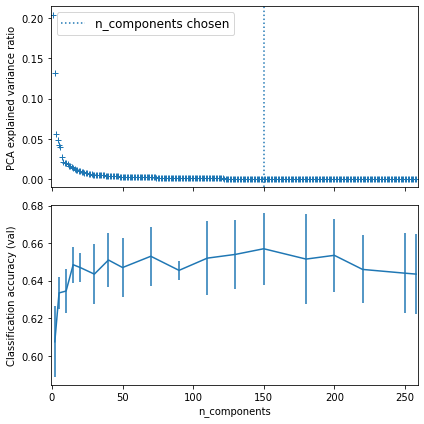

In [14]:
pca = PCA()
classifier = LogisticRegression(max_iter=1000)
pipe = Pipeline([("pca", pca), ("classifier", classifier)])
param_grid = {
    "pca__n_components": [2,5,10,15,20,30,40,50,70,90,110,130,150,180,200,220,250,258]
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1, verbose=2, cv = ts_cv)
search.fit(X_std, y)

plot_pca_spectrum(X_std, search)

### K nearest neighb

Fitting 4 folds for each of 14 candidates, totalling 56 fits
Best n parameter pca : 5 (CV mean score=0.586):


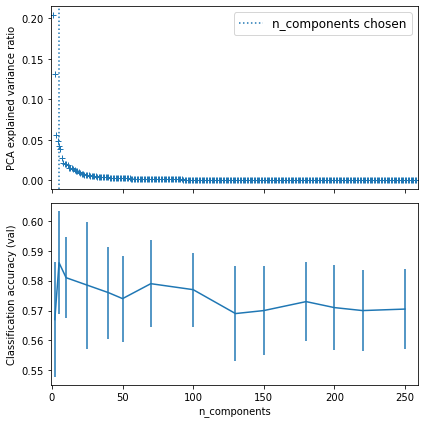

In [19]:
pca = PCA()
classifier = KNeighborsClassifier()
pipe = Pipeline([("pca", pca), ("classifier", classifier)])
param_grid = {
    "pca__n_components" : [2,5,10,25,40,50,70,100,130,150,180,200,220,250]
}
search = GridSearchCV(pipe, param_grid, n_jobs=2, verbose=2, cv = ts_cv)
search.fit(X_std, y)

plot_pca_spectrum(X_std, search)

### Ridge Classifier

Fitting 4 folds for each of 17 candidates, totalling 68 fits
Best n parameter pca : 150 (CV mean score=0.656):


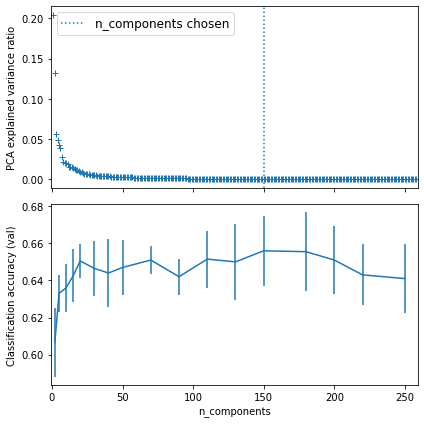

In [18]:
pca = PCA()
classifier = RidgeClassifier()
pipe = Pipeline([("pca", pca), ("classifier", classifier)])
param_grid = {
    "pca__n_components": [2,5,10,15,20,30,40,50,70,90,110,130,150,180,200,220,250]
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1, verbose=2, cv = ts_cv)
search.fit(X_std, y)

plot_pca_spectrum(X_std, search)

# Hyperparameter tuning

Tree based classifiers are sensitive to data rotation. After experiments, we concluded it would be better not to apply PCA to our Tree classifiers.

In [33]:
tuned_clf = {}
best_parameters = {}
hyper_param = {}
def tune_hyperparameters(X, Y, param, pipe, n_jobs_=-1, verbose_=2):
    search = GridSearchCV(pipe, param, n_jobs=n_jobs_, verbose=verbose_, cv = ts_cv)
    search.fit(X,Y)
    return search
def analyse_params(name, classifier):
    print(name, "tuning... ", end='')
    pipe, param,n_jobs = hyper_param[name]
    start_time = time.time()
    search = tune_hyperparameters(X_std, y, param, pipe, n_jobs_=n_jobs)
    print(f'{time.time() - start_time:.3f} seconds')
    print(f"new score: {search.best_score_:.4f}  |  old score: {clf_acc[name]}  |   params: {search.best_params_}\n")
    tuned_clf[name] = search.best_estimator_
    best_parameters[name] = search.best_params_
    #clf_acc[name] = search.best_score_

In [35]:
#Ridge Classifier
n_jobs=-1
pca = PCA()
classifier = RidgeClassifier()
pipe = Pipeline([("pca", pca), ("classifier", classifier)])
param = {
    "pca__n_components": [140,150,160,180,190,200,210,220,222],
    "classifier__alpha": [8.0,10.0,13.0]
}
hyper_param['Ridge Classifier'] = (pipe, param,n_jobs)
analyse_params('Ridge Classifier', classifiers['Ridge Classifier'])

Ridge Classifier tuning... Fitting 4 folds for each of 27 candidates, totalling 108 fits
24.538 seconds
new score: 0.6575  |  old score: 0.646  |   params: {'classifier__alpha': 13.0, 'pca__n_components': 180}



In [43]:
#Random Forest
n_jobs=-1
classifier = RandomForestClassifier()
pipe = Pipeline([("classifier", classifier)])
param = {
    "classifier__n_estimators" : [100],
    "classifier__max_features" : [6,8,10,12]
}
hyper_param['Random Forest'] = (pipe, param,n_jobs)
analyse_params('Random Forest', classifiers['Random Forest'])

Random Forest tuning... Fitting 4 folds for each of 4 candidates, totalling 16 fits
36.015 seconds
new score: 0.6360  |  old score: 0.625  |   params: {'classifier__max_features': 6, 'classifier__n_estimators': 100}



In [68]:
#Gradient Boosting
n_jobs = -1
classifier = GradientBoostingClassifier()
pipe = Pipeline([("classifier", classifier)])
param = {
    "classifier__n_estimators" : [100],
    "classifier__learning_rate" : [0.05, 0.1, 0.15],
    "classifier__subsample" : [0.7, 1.0],
    "classifier__max_depth" : [3, 7]
}
hyper_param['Gradient Boosting'] = (pipe, param,n_jobs)
analyse_params('Gradient Boosting', classifiers['Gradient Boosting'])

Gradient Boosting tuning... Fitting 4 folds for each of 12 candidates, totalling 48 fits
913.682 seconds
new score: 0.6560  |  old score: 0.645  |   params: {'classifier__learning_rate': 0.05, 'classifier__max_depth': 7, 'classifier__n_estimators': 100, 'classifier__subsample': 1.0}



In [45]:
#Logistic Regression
n_jobs=-1
pca = PCA()
classifier = LogisticRegression(max_iter=1000)
pipe = Pipeline([("pca", pca), ("classifier", classifier)])
param = {
    "pca__n_components": [50,60,70,90,130],
    "classifier__C" : [10, 1.0, 0.5, 0.4, 0.3, 0.1, 0.05]
}
hyper_param['Logistic Regression'] = (pipe, param,n_jobs)
analyse_params('Logistic Regression', classifiers['Logistic Regression'])

Logistic Regression tuning... Fitting 4 folds for each of 35 candidates, totalling 140 fits
22.404 seconds
new score: 0.6605  |  old score: 0.6435000000000001  |   params: {'classifier__C': 0.1, 'pca__n_components': 70}



In [69]:
#XGBoost
n_jobs = -1
classifier = XGBClassifier(use_label_encoder=False, eval_metric='rmse')
pipe = Pipeline([("classifier", classifier)])
param = {
    'classifier__n_estimators': [100],
    'classifier__max_depth': [6],
    'classifier__learning_rate': [0.3, 0.4, 0.6],
    'classifier__min_child_weight': [0.1, 0.5, 1, 10]
}
hyper_param['XGBoost'] = (pipe, param,n_jobs)
analyse_params('XGBoost', classifiers['XGBoost'])

XGBoost tuning... Fitting 4 folds for each of 12 candidates, totalling 48 fits
2460.957 seconds
new score: 0.6210  |  old score: 0.5985  |   params: {'classifier__learning_rate': 0.6, 'classifier__max_depth': 6, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 100}



In [58]:
#Naive Bayes
n_jobs=-1
pca = PCA()
classifier = GaussianNB()
pipe = Pipeline([('pca', pca), ("classifier", classifier)])
param = {
    "pca__n_components": [90,100,110],
    'classifier__var_smoothing': np.logspace(0,-9, num=20)
}
hyper_param['Naive Bayes'] = (pipe, param,n_jobs)
analyse_params('Naive Bayes', classifiers['Naive Bayes'])

Naive Bayes tuning... Fitting 4 folds for each of 60 candidates, totalling 240 fits
31.483 seconds
new score: 0.6405  |  old score: 0.636  |   params: {'classifier__var_smoothing': 0.0379269019073225, 'pca__n_components': 90}



In [59]:
#Decision Tree
n_jobs=-1
classifier = DecisionTreeClassifier()
pipe = Pipeline([("classifier", classifier)])
param = {
    'classifier__max_depth': [2, 3, 10, 20, 30],
    'classifier__min_samples_leaf': [2, 3, 5, 10, 15, 20],
    'classifier__criterion': ["gini", "entropy"]
}
hyper_param['Decision Tree'] = (pipe, param,n_jobs)
analyse_params('Decision Tree', classifiers['Decision Tree'])

Decision Tree tuning... Fitting 4 folds for each of 60 candidates, totalling 240 fits
58.917 seconds
new score: 0.6025  |  old score: 0.5525  |   params: {'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 3}



In [60]:
#K Nearest Neighbors
n_jobs = 3
pca = PCA()
classifier = KNeighborsClassifier()
pipe = Pipeline([("pca", pca), ("classifier", classifier)])
param = {
    "pca__n_components": [10,30,70,130,220],
    "classifier__weights" : ['uniform', 'distance'],
    "classifier__metric" : ['euclidean', 'manhattan', 'minkowski'],
    "classifier__n_neighbors" : [70,80,90,100]
}
hyper_param['k Nearest Neighbors'] = (pipe, param,n_jobs)
analyse_params('k Nearest Neighbors', classifiers['k Nearest Neighbors'])

k Nearest Neighbors tuning... Fitting 4 folds for each of 180 candidates, totalling 720 fits
179.791 seconds
new score: 0.6290  |  old score: 0.5705  |   params: {'classifier__metric': 'minkowski', 'classifier__n_neighbors': 80, 'classifier__weights': 'distance', 'pca__n_components': 70}



In [70]:
#AdaBoost
n_jobs = -1
classifier = AdaBoostClassifier()
pipe = Pipeline([("classifier", classifier)])
param = {
    'classifier__n_estimators' : [50,100,500],
    'classifier__learning_rate' : [0.0001, 0.001, 0.01, 0.1, 1.0,1.5]
}
hyper_param['AdaBoost'] = (pipe, param,n_jobs)
analyse_params('AdaBoost', classifiers['AdaBoost'])

AdaBoost tuning... Fitting 4 folds for each of 18 candidates, totalling 72 fits
741.150 seconds
new score: 0.6440  |  old score: 0.625  |   params: {'classifier__learning_rate': 0.1, 'classifier__n_estimators': 500}



In [71]:
#Neural Net
n_jobs = -1
pca = PCA()
classifier = MLPClassifier(max_iter=1000)
pipe = Pipeline([("pca", pca), ("classifier", classifier)])
param = {
    #"pca__n_components": [222],
    'classifier__activation': ['tanh', 'relu'],
    'classifier__solver': ['sgd', 'adam'],
    'classifier__alpha': [0.0001, 0.05],
    'classifier__learning_rate': ['constant','adaptive']
}
hyper_param['Neural Net'] = (pipe, param,n_jobs)
analyse_params('Neural Net', classifiers['Neural Net'])

Neural Net tuning... Fitting 4 folds for each of 16 candidates, totalling 64 fits
1728.437 seconds
new score: 0.5925  |  old score: 0.5745  |   params: {'classifier__activation': 'tanh', 'classifier__alpha': 0.0001, 'classifier__learning_rate': 'adaptive', 'classifier__solver': 'adam'}



In [74]:
#Neural Net
n_jobs = -1
classifier = MLPClassifier(max_iter=1000)
pipe = Pipeline([("classifier", classifier)])
param = {
    #"pca__n_components": [222],
    'classifier__activation': ['tanh'],
    'classifier__solver': ['adam'],
    'classifier__alpha': [0.0001],
    'classifier__learning_rate': ['adaptive']
}
hyper_param['Neural Net'] = (pipe, param,n_jobs)
analyse_params('Neural Net', classifiers['Neural Net'])

Neural Net tuning... Fitting 4 folds for each of 1 candidates, totalling 4 fits
1572.477 seconds
new score: 0.5880  |  old score: 0.5745  |   params: {'classifier__activation': 'tanh', 'classifier__alpha': 0.0001, 'classifier__learning_rate': 'adaptive', 'classifier__solver': 'adam'}



/home/piopie/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [67]:
#QDA
n_jobs = -1
classifier = QuadraticDiscriminantAnalysis()
pipe = Pipeline([("pca", pca), ("classifier", classifier)])
param = {
    "pca__n_components": [100, 150, 200],
    'classifier__reg_param': [0.1, 0.5, 0.7]
}
hyper_param['QDA'] = (pipe, param,n_jobs)
analyse_params('QDA', classifiers['QDA'])

QDA tuning... Fitting 4 folds for each of 9 candidates, totalling 36 fits
14.551 seconds
new score: 0.6375  |  old score: 0.6025  |   params: {'classifier__reg_param': 0.5, 'pca__n_components': 150}



In [72]:
#SVM
n_jobs = -1
classifier = SVC()
pipe = Pipeline([("classifier", classifier)])
param = {
    "classifier__kernel" : ['poly', 'rbf', 'sigmoid'],
    "classifier__C" : [50, 10, 1.0, 0.1, 0.01],
    "classifier__gamma" : ['scale']
}
hyper_param['SVM'] = (pipe, param,n_jobs)
analyse_params('SVM', classifiers['SVM'])

SVM tuning... Fitting 4 folds for each of 15 candidates, totalling 60 fits
1913.657 seconds
new score: 0.6405  |  old score: 0.6405  |   params: {'classifier__C': 1.0, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}



In [78]:
# saved tuned models
best_models = {
    'Ridge Classifier' : Pipeline(steps=[('pca', PCA(n_components=180)),
                ('classifier', RidgeClassifier(alpha=13.0))]),
    
    'Random Forest' : RandomForestClassifier(max_features=6),
    
    'Gradient Boosting' : GradientBoostingClassifier(learning_rate=0.05, max_depth=7),
    
    'Logistic Regression' : Pipeline(steps=[('pca', PCA(n_components=70)),
                ('classifier', LogisticRegression(C=0.1, max_iter=1000))]),
    
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='rmse', learning_rate = 0.6, max_depth = 6, min_child_weight = 1, n_estimators = 100),
    
    'Naive Bayes' : Pipeline(steps=[('pca', PCA(n_components=90)), ('classifier', GaussianNB(var_smoothing = 0.0379))]),
    
    'Decision Tree' : DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=3),
    
    'k Nearest Neighbors' : Pipeline(steps=[('pca', PCA(n_components=70)),
                ('classifier',
                 KNeighborsClassifier(metric='minkowski', n_neighbors=80,
                                      weights='distance'))]),
    
    'AdaBoost' :  Pipeline(steps=[('classifier', AdaBoostClassifier(n_estimators=500, learning_rate = 0.1))]),
    
    'Neural Net' :  Pipeline(steps=[('pca', PCA()),
                ('classifier', MLPClassifier(max_iter=1000, activation = 'tanh', 
                                alpha = 0.0001, learning_rate = 'adaptive', solver = 'adam'))]),
    
    "QDA" : Pipeline(steps=[('pca', PCA(n_components=70)), ('classifier', QuadraticDiscriminantAnalysis(reg_param=0.5))]),
    
    "SVM" : Pipeline(steps=[('classifier', SVC(C=1.0, kernel='rbf'))]),
}

In [81]:
clf_acc_tuned = {}
clf_scores_tuned = {}
for name, classifier in best_models.items():
    print("Evaluating...",name)
    scores = cross_val_score(classifier, X_std, y, cv=ts_cv, n_jobs=-1)
    clf_scores_tuned[name] = scores
    print(f'old accuracy: {clf_acc[name]}')
    print(f'accuracy {scores.mean():.4f} with a standard deviation of {scores.std():.2f}')
    clf_acc_tuned[name] = scores.mean()

Evaluating... Ridge Classifier
old accuracy: 0.646
accuracy 0.6545 with a standard deviation of 0.02
Evaluating... Random Forest
old accuracy: 0.632
accuracy 0.6290 with a standard deviation of 0.02
Evaluating... Gradient Boosting
old accuracy: 0.644
accuracy 0.6500 with a standard deviation of 0.02
Evaluating... Logistic Regression
old accuracy: 0.6435000000000001
accuracy 0.6595 with a standard deviation of 0.02
Evaluating... XGBoost
old accuracy: 0.5985
accuracy 0.6210 with a standard deviation of 0.01
Evaluating... Naive Bayes
old accuracy: 0.636
accuracy 0.6420 with a standard deviation of 0.02
Evaluating... Decision Tree
old accuracy: 0.551
accuracy 0.5995 with a standard deviation of 0.01
Evaluating... k Nearest Neighbors
old accuracy: 0.5705
accuracy 0.6250 with a standard deviation of 0.04
Evaluating... AdaBoost
old accuracy: 0.625
accuracy 0.6440 with a standard deviation of 0.02
Evaluating... Neural Net
old accuracy: 0.5655
accuracy 0.5735 with a standard deviation of 0.01
E

## Model Correlation

In [84]:
# find correlation of models predictions
preds = {}
for name,clf in best_models.items():
    clf.fit(X_std[-20000:-10000], y[-20000:-10000])
    pred = clf.predict(X_std[-20000:-10000])
    preds[name] = pred
preds_df = pd.DataFrame(preds)

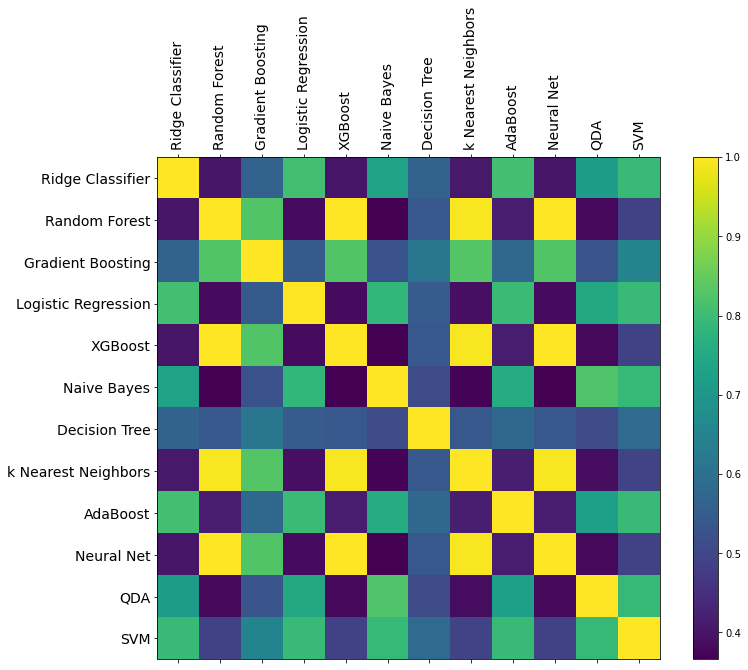

In [85]:
f = plt.figure(figsize=(12,9))
plt.matshow(preds_df.corr(), fignum=f.number)
plt.xticks(range(0, preds_df.columns.shape[0]), preds_df.columns, fontsize=14, rotation=90)
plt.yticks(range(0, preds_df.columns.shape[0]), preds_df.columns, fontsize=14)
cb = plt.colorbar()

# Stacking

We will perform 2 stackings:  on all models and the least correlated models.

     Ridge Classifier, Logistic Regression, Naive Bayes, KNN, Neural Net, AdaBoost, Decision Tree, XGBoost
     
We will cross validate Stacking with 4 folds:

    10% of fold validation
    2/3 of remaining fold for base models training
    1/3 of remaining fold for meta model training

In [102]:
ts_cv = TimeSeriesSplit(gap=0, max_train_size=20000, n_splits=4, test_size=2000)
folds = []
for train_index, test_index in ts_cv.split(X_std):
    X_fold = X_std.iloc[np.hstack((train_index, test_index))]
    y_fold = y[np.hstack((train_index, test_index))]
    folds.append((X_fold, y_fold))
print()

In [104]:
meta_model = XGBClassifier(use_label_encoder=False, eval_metric='rmse')
base_models_1 = {
    'Ridge Classifier' : best_models['Ridge Classifier'],
    'Random Forest' : best_models['Random Forest'],
    'Gradient Boosting' : best_models['Gradient Boosting'],
    'Logistic Regression' : best_models['Logistic Regression'],
    'XGBoost': best_models['XGBoost'],
    'Naive Bayes' : best_models['Naive Bayes'],
    'Decision Tree' : best_models['Decision Tree'],
    'k Nearest Neighbors' : best_models['k Nearest Neighbors'],
    'AdaBoost' : best_models['AdaBoost'],
    'Neural Net' :  best_models['Neural Net'],
    "QDA" : best_models['QDA'],
    "SVM" : best_models['SVM'],
}

In [105]:
base_models_2 = {
    'Logistic Regression' : best_models['Logistic Regression'],
    'Ridge Classifier' : best_models['Ridge Classifier'],
    'Gradient Boosting' : best_models['Gradient Boosting'],
    'Naive Bayes' : best_models['Naive Bayes'],
    'AdaBoost' : best_models['AdaBoost'],
    "QDA" : best_models['QDA'],
    "SVM" : best_models['SVM'],
}

In [106]:
base_models_prob_1 = {
    'Logistic Regression' : best_models['Logistic Regression'],
    'Random Forest' : best_models['Random Forest'],
    'Gradient Boosting' : best_models['Gradient Boosting'],
    'XGBoost': best_models['XGBoost'],
    'Naive Bayes' : best_models['Naive Bayes'],
    'k Nearest Neighbors' : best_models['k Nearest Neighbors'],
    'AdaBoost' : best_models['AdaBoost'],
    "QDA" : best_models['QDA'],
    "SVM" : SVC(C=1.0, kernel='rbf', probability=True)
}

In [107]:
base_models_prob_2 = {
    'Logistic Regression' : best_models['Logistic Regression'],
    'Gradient Boosting' : best_models['Gradient Boosting'],
    'Naive Bayes' : best_models['Naive Bayes'],
    'AdaBoost' : best_models['AdaBoost'],
    "QDA" : best_models['QDA'],
    "SVM" : SVC(C=1.0, kernel='rbf', probability=True)
}

In [108]:
def fold_scoring(X, y, meta_model, base_models, return_meta_args=False, probabilities=False):
    # accuracy of models
    df_acc = pd.DataFrame(columns=base_models.keys()) # Columns of DF will accord with base_dict keys
    
    # model predictions for the meta model
    train_predictions = {}
    val_predictions = {}
    
    # Split the data length into 2/3 base-training data and 1/3 meta-training data
    
    n_valid = round(X.shape[0] * 0.1)
    n_models = X.shape[0] - n_valid # n_valid is given as per above
    n_meta = round(n_models/3) # data size for meta model
    n_base = n_models - n_meta # data size for base models
    
    X_base = X.iloc[:n_base,:]
    X_meta = X.iloc[n_base:(n_base + n_meta),:]
    X_valid = X.iloc[n_models:(n_models + n_valid),:]
    
    y_base = y[:n_base]
    y_meta = y[n_base:(n_base + n_meta)]
    y_valid = y[n_models:(n_models + n_valid)]
    
    # Fit the base models to the base-training set, and generate predictions
    for name, clf in base_models.items():
        clf.fit(X_base, y_base)
        
        if probabilities:
            pred_meta = clf.predict_proba(X_meta)# Generate predictions on meta-training set
            train_predictions[f'{name}_0'] = list(pred_meta[:,0])
            train_predictions[f'{name}_1'] = list(pred_meta[:,1])
            
            pred_valid = clf.predict_proba(X_valid) # Generate predictions on validation set for meta model
            val_predictions[f'{name}_0'] = list(pred_valid[:,0])
            val_predictions[f'{name}_1'] = list(pred_valid[:,1])
        else:
            pred_meta = list(clf.predict(X_meta)) # Generate predictions on meta-training set
            train_predictions[name] = pred_meta # Append predictions to dictionary
        
            pred_valid = list(clf.predict(X_valid)) # Generate predictions on validation set for meta model
            val_predictions[name] = pred_valid
            
        pred_valid = list(clf.predict(X_valid)) # Generate predictions on validation set for meta model
        df_acc[name] = pd.Series(round(accuracy_score(pred_valid, y_valid), 5)) # save score of classifier
    
    # Transform dictionary of predictions for meta model into DataFrames        
    df_meta_train = pd.DataFrame(train_predictions)
    df_meta_valid = pd.DataFrame(val_predictions)
    
    # Train meta model using base models' predictions of meta-training set
    meta_model.fit(df_meta_train, y_meta)
    
    # Generate meta model predictions of validation set
    meta_predictions = meta_model.predict(df_meta_valid)  
    #save_predictor(meta_predictions)
    
    df_acc['Stack Model'] = pd.Series(round(accuracy_score(meta_predictions, y_valid), 5)) # save score of Stack Model
    if return_meta_args:
        return df_acc, df_meta_train, y_meta, df_meta_valid, y_valid
    return df_acc

In [109]:
folds_res_1 = []
for i,f in enumerate(folds):
    print(f'Evaluating fold {i + 1}...')
    folds_res_1.append(fold_scoring(*f, meta_model, base_models_1,return_meta_args=True))

Evaluating fold 1...
Evaluating fold 2...
Evaluating fold 3...
Evaluating fold 4...


In [111]:
acc_df_1 = pd.DataFrame(pd.concat([acc[0] for acc in folds_res_1]).mean(), columns = ['CV accuracy'])
acc_df_1['Classifier'] = acc_df_1.index
acc_df_1 = acc_df_1.sort_values(by=['CV accuracy'])
acc_df_1

,CV accuracy,Classifier
Neural Net,0.571022,Neural Net
Decision Tree,0.586933,Decision Tree
XGBoost,0.603750,XGBoost
QDA,0.627955,QDA
Stack Model,0.630792,Stack Model
k Nearest Neighbors,0.633410,k Nearest Neighbors
Naive Bayes,0.634320,Naive Bayes
AdaBoost,0.635343,AdaBoost
SVM,0.636138,SVM
Random Forest,0.636363,Random Forest


In [112]:
folds_res_2 = []
meta_model = LogisticRegression(max_iter=1000)
for i,f in enumerate(folds):
    print(f'Evaluating fold {i + 1}...')
    folds_res_2.append(fold_scoring(*f, meta_model, base_models_2,return_meta_args=True))

Evaluating fold 1...
Evaluating fold 2...
Evaluating fold 3...
Evaluating fold 4...


In [113]:
acc_df_2 = pd.DataFrame(pd.concat([acc[0] for acc in folds_res_2]).mean(), columns = ['CV accuracy'])
acc_df_2['Classifier'] = acc_df_2.index
acc_df_2 = acc_df_2.sort_values(by=['CV accuracy'])
acc_df_2

,CV accuracy,Classifier
QDA,0.629545,QDA
Gradient Boosting,0.631933,Gradient Boosting
Naive Bayes,0.634090,Naive Bayes
AdaBoost,0.635230,AdaBoost
SVM,0.636138,SVM
Ridge Classifier,0.641023,Ridge Classifier
Logistic Regression,0.643182,Logistic Regression
Stack Model,0.644092,Stack Model


In [114]:
folds_res_prob_1 = []
meta_model = LogisticRegression(max_iter=1000)
for i,f in enumerate(folds):
    print(f'Evaluating fold {i + 1}...')
    folds_res_prob_1.append(fold_scoring(*f, meta_model, base_models_prob_1,return_meta_args=True,probabilities=True))

Evaluating fold 1...
Evaluating fold 2...
Evaluating fold 3...
Evaluating fold 4...


In [115]:
acc_df_prob_1 = pd.DataFrame(pd.concat([acc[0] for acc in folds_res_prob_1]).mean(), columns = ['CV accuracy'])
acc_df_prob_1['Classifier'] = acc_df_prob_1.index
acc_df_prob_1 = acc_df_prob_1.sort_values(by=['CV accuracy'])
acc_df_prob_1

,CV accuracy,Classifier
XGBoost,0.603750,XGBoost
Random Forest,0.625000,Random Forest
QDA,0.627160,QDA
k Nearest Neighbors,0.631702,k Nearest Neighbors
Gradient Boosting,0.632047,Gradient Boosting
Naive Bayes,0.633520,Naive Bayes
AdaBoost,0.635570,AdaBoost
SVM,0.636138,SVM
Stack Model,0.643637,Stack Model
Logistic Regression,0.645000,Logistic Regression


In [116]:
folds_res_prob_2 = []
meta_model = LogisticRegression(max_iter=1000)
for i,f in enumerate(folds):
    print(f'Evaluating fold {i + 1}...')
    folds_res_prob_2.append(fold_scoring(*f, meta_model, base_models_prob_2,return_meta_args=True,probabilities=True))

Evaluating fold 1...
Evaluating fold 2...
Evaluating fold 3...
Evaluating fold 4...


In [117]:
acc_df_prob_2 = pd.DataFrame(pd.concat([acc[0] for acc in folds_res_prob_2]).mean(), columns = ['CV accuracy'])
acc_df_prob_2['Classifier'] = acc_df_prob_2.index
acc_df_prob_2 = acc_df_prob_2.sort_values(by=['CV accuracy'])
acc_df_prob_2

,CV accuracy,Classifier
Gradient Boosting,0.627387,Gradient Boosting
QDA,0.630343,QDA
Naive Bayes,0.633862,Naive Bayes
AdaBoost,0.634660,AdaBoost
SVM,0.636138,SVM
Stack Model,0.642500,Stack Model
Logistic Regression,0.643975,Logistic Regression


# Testing meta model

In [121]:
for name, classifier in classifiers.items():
    print("Evaluating...",name)
    scores = []
    for fold in folds_res_2:
        clf = classifier
        clf.fit(fold[1],fold[2])
        pred = clf.predict(fold[3])
        scores.append(accuracy_score(pred, fold[4]))
    print(scores)
    print(f'accuracy {sum(scores)/4:.4f}')
    print()

Evaluating... Ridge Classifier
[0.6631818181818182, 0.6372727272727273, 0.6336363636363637, 0.6409090909090909]
accuracy 0.6438

Evaluating... Random Forest
[0.6554545454545454, 0.6322727272727273, 0.6236363636363637, 0.6309090909090909]
accuracy 0.6356

Evaluating... Gradient Boosting
[0.6622727272727272, 0.63, 0.6209090909090909, 0.63]
accuracy 0.6358

Evaluating... Logistic Regression
[0.6631818181818182, 0.6377272727272727, 0.6359090909090909, 0.6395454545454545]
accuracy 0.6441

Evaluating... XGBoost
[0.6545454545454545, 0.6359090909090909, 0.6236363636363637, 0.6254545454545455]
accuracy 0.6349

Evaluating... Naive Bayes
[0.66, 0.635, 0.6381818181818182, 0.6418181818181818]
accuracy 0.6438

Evaluating... Decision Tree
[0.6545454545454545, 0.6327272727272727, 0.6186363636363637, 0.6295454545454545]
accuracy 0.6339

Evaluating... k Nearest Neighbors
[0.65, 0.6227272727272727, 0.6181818181818182, 0.6181818181818182]
accuracy 0.6273

Evaluating... AdaBoost
[0.6631818181818182, 0.6377

In [145]:
for name, classifier in classifiers.items():
    print("Evaluating...",name)
    scores = []
    for fold in folds_res_prob_1:
        clf = classifier
        clf.fit(fold[1],fold[2])
        pred = clf.predict(fold[3])
        scores.append(accuracy_score(pred, fold[4]))
    print(scores)
    print(f'accuracy {sum(scores)/4:.4f}')
    print()

Evaluating... Ridge Classifier
[0.6618181818181819, 0.63, 0.6331818181818182, 0.6463636363636364]
accuracy 0.6428

Evaluating... Random Forest
[0.6468181818181818, 0.6245454545454545, 0.6418181818181818, 0.6131818181818182]
accuracy 0.6316

Evaluating... Gradient Boosting
[0.66, 0.6295454545454545, 0.6354545454545455, 0.645]
accuracy 0.6425

Evaluating... Logistic Regression
[0.6631818181818182, 0.6309090909090909, 0.6336363636363637, 0.6468181818181818]
accuracy 0.6436

Evaluating... XGBoost
[0.6409090909090909, 0.6004545454545455, 0.6190909090909091, 0.6140909090909091]
accuracy 0.6186

Evaluating... Naive Bayes
[0.6568181818181819, 0.6336363636363637, 0.6354545454545455, 0.6518181818181819]
accuracy 0.6444

Evaluating... Decision Tree
[0.5736363636363636, 0.5654545454545454, 0.5768181818181818, 0.5409090909090909]
accuracy 0.5642

Evaluating... k Nearest Neighbors
[0.6204545454545455, 0.59, 0.600909090909091, 0.5940909090909091]
accuracy 0.6014

Evaluating... AdaBoost
[0.65227272727

/home/piopie/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/piopie/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/piopie/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/piopie/anaconda3/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


[0.6545454545454545, 0.6322727272727273, 0.6277272727272727, 0.65]
accuracy 0.6411



# Can we prune our data to get better accuracy?

## How much data will we prune?

In [132]:
def get_indexes(pred_prob, prob=0.7):
    indexes = []
    for i in range(pred_prob.shape[0]):
        if pred_prob[i,0] >= prob or pred_prob[i,1] >= prob:
            indexes.append(i)
    return indexes

In [133]:
def get_indexes_fold(fold, prob=0.7):
    indexes = []
    for i in range(fold.shape[0]):
        if fold.iloc[i,0] >= prob or fold.iloc[i,1] >= prob:
            indexes.append(i)
    return indexes

In [140]:
for prob in [0.55, 0.6, 0.65, 0.70, 0.75, 0.8]:
    scores=[]
    account=[]
    print('probability', prob)
    for fold in folds_res_prob_2:
        clf = LogisticRegression(max_iter=1000)
        clf.fit(fold[1],fold[2])
        indexes = get_indexes(clf.predict_proba(fold[3]), prob)
        account.append(len(indexes) / fold[3].shape[0])
        pred = clf.predict(fold[3].iloc[indexes])
        scores.append(accuracy_score(pred, fold[4][indexes]))
    #print(scores)
    print(f'accuracy {sum(scores)/4:.4f}')
    print(f'take into account {sum(account)/4:.4f} matches')
    print()

probability 0.55
accuracy 0.6720
take into account 0.8313 matches

probability 0.6
accuracy 0.7057
take into account 0.6685 matches

probability 0.65
accuracy 0.7330
take into account 0.5209 matches

probability 0.7
accuracy 0.7675
take into account 0.3793 matches

probability 0.75
accuracy 0.7984
take into account 0.2547 matches

probability 0.8
accuracy 0.8474
take into account 0.1366 matches



In [142]:
for prob in [0.55, 0.6, 0.65, 0.70, 0.75, 0.8]:
    scores=[]
    account=[]
    print('probability', prob)
    for train_index, test_index in ts_cv.split(X_std):
        X_train, X_test = X_std.iloc[train_index], X_std.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = LogisticRegression(max_iter=1000)
        clf.fit(X_train, y_train)
        indexes = get_indexes(clf.predict_proba(X_test), prob)
        account.append(len(indexes) / X_test.shape[0])
        pred = clf.predict(X_test.iloc[indexes])
        scores.append(accuracy_score(pred, y_test[indexes]))
    #print(scores)
    print(f'accuracy {sum(scores)/4:.4f}')
    print(f'take into account {sum(account)/4:.4f} matches')
    print()

probability 0.55
accuracy 0.6684
take into account 0.8353 matches

probability 0.6
accuracy 0.6937
take into account 0.6654 matches

probability 0.65
accuracy 0.7286
take into account 0.5125 matches

probability 0.7
accuracy 0.7603
take into account 0.3794 matches

probability 0.75
accuracy 0.7917
take into account 0.2700 matches

probability 0.8
accuracy 0.8182
take into account 0.1789 matches



# Fancy plots

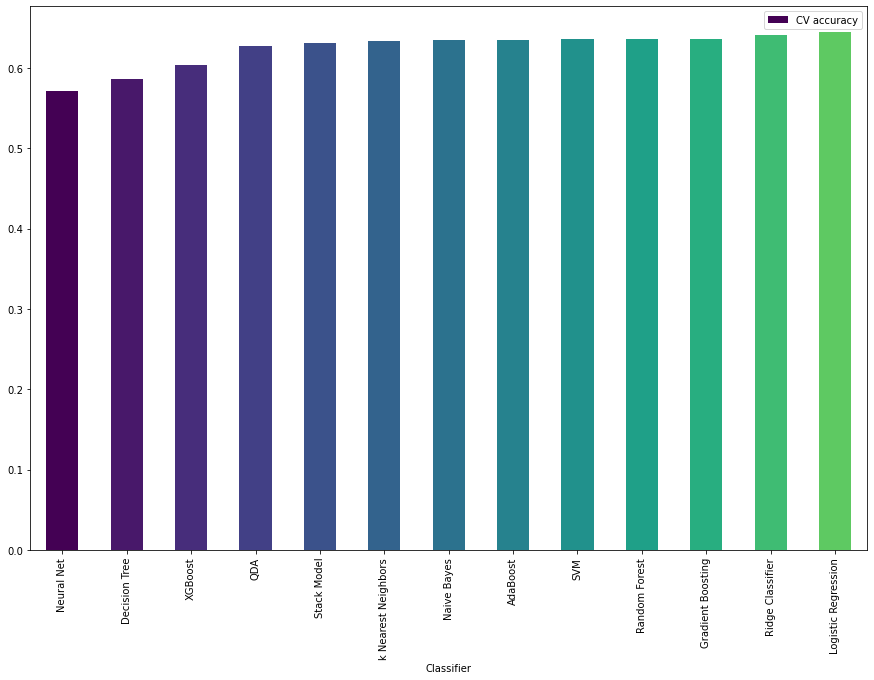

In [128]:
v = cm.get_cmap('viridis')
colors = v(np.linspace(0, 1, acc_df_1.shape[0] + 4))
fig, ax0 = plt.subplots(figsize=(15, 10))
acc_df_1.plot.bar(x = 'Classifier', y='CV accuracy', ax = ax0, color = colors)

# FINAL MODEL

In [146]:
# saved tuned models (reset these models)
best_models = {
    'Ridge Classifier' : Pipeline(steps=[('pca', PCA(n_components=180)),
                ('classifier', RidgeClassifier(alpha=13.0))]),
    
    'Random Forest' : RandomForestClassifier(max_features=6),
    
    'Gradient Boosting' : GradientBoostingClassifier(learning_rate=0.05, max_depth=7),
    
    'Logistic Regression' : Pipeline(steps=[('pca', PCA(n_components=70)),
                ('classifier', LogisticRegression(C=0.1, max_iter=1000))]),
    
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='rmse', learning_rate = 0.6, max_depth = 6, min_child_weight = 1, n_estimators = 100),
    
    'Naive Bayes' : Pipeline(steps=[('pca', PCA(n_components=90)), ('classifier', GaussianNB(var_smoothing = 0.0379))]),
    
    'Decision Tree' : DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=3),
    
    'k Nearest Neighbors' : Pipeline(steps=[('pca', PCA(n_components=70)),
                ('classifier',
                 KNeighborsClassifier(metric='minkowski', n_neighbors=80,
                                      weights='distance'))]),
    
    'AdaBoost' :  Pipeline(steps=[('classifier', AdaBoostClassifier(n_estimators=500, learning_rate = 0.1))]),
    
    'Neural Net' :  Pipeline(steps=[('pca', PCA()),
                ('classifier', MLPClassifier(max_iter=1000, activation = 'tanh', 
                                alpha = 0.0001, learning_rate = 'adaptive', solver = 'adam'))]),
    
    "QDA" : Pipeline(steps=[('pca', PCA(n_components=70)), ('classifier', QuadraticDiscriminantAnalysis(reg_param=0.5))]),
    
    "SVM" : Pipeline(steps=[('classifier', SVC(C=1.0, kernel='rbf'))]),
}

In [147]:
base_models_prob_1 = {
    'Logistic Regression' : best_models['Logistic Regression'],
    'Random Forest' : best_models['Random Forest'],
    'Gradient Boosting' : best_models['Gradient Boosting'],
    'XGBoost': best_models['XGBoost'],
    'Naive Bayes' : best_models['Naive Bayes'],
    'k Nearest Neighbors' : best_models['k Nearest Neighbors'],
    'AdaBoost' : best_models['AdaBoost'],
    "QDA" : best_models['QDA'],
    "SVM" : SVC(C=1.0, kernel='rbf', probability=True)
}

In [149]:
folds_final = []
meta_model = LogisticRegression(max_iter=1000)
for i,f in enumerate(folds):
    print(f'Evaluating fold {i + 1}...')
    folds_final.append(fold_scoring(*f, meta_model, base_models_prob_1,return_meta_args=True,probabilities=True))

Evaluating fold 1...
Evaluating fold 2...
Evaluating fold 3...
Evaluating fold 4...


In [150]:
acc_df_final = pd.DataFrame(pd.concat([acc[0] for acc in folds_final]).mean(), columns = ['CV accuracy'])
acc_df_final['Classifier'] = acc_df_final.index
acc_df_final = acc_df_final.sort_values(by=['CV accuracy'])
acc_df_final

,CV accuracy,Classifier
XGBoost,0.603750,XGBoost
Random Forest,0.624090,Random Forest
Gradient Boosting,0.628750,Gradient Boosting
QDA,0.631250,QDA
k Nearest Neighbors,0.632840,k Nearest Neighbors
Naive Bayes,0.634320,Naive Bayes
AdaBoost,0.635343,AdaBoost
SVM,0.636138,SVM
Stack Model,0.642840,Stack Model
Logistic Regression,0.644205,Logistic Regression


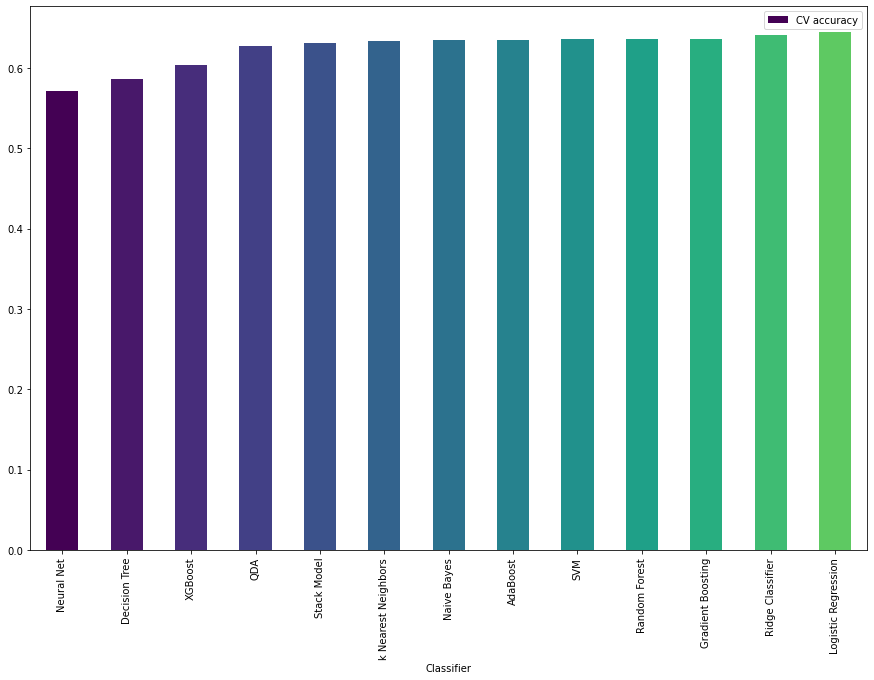

In [151]:
v = cm.get_cmap('viridis')
colors = v(np.linspace(0, 1, acc_df_1.shape[0] + 4))
fig, ax0 = plt.subplots(figsize=(15, 10))
acc_df_1.plot.bar(x = 'Classifier', y='CV accuracy', ax = ax0, color = colors)

In [152]:
for i,fold in enumerate(folds_final):
    fold[1].to_csv(f'predictions\X_train_{i}.csv', index=False)
    np.save(f'predictions\y_train_{i}.npy', fold[2])
    fold[3].to_csv(f'predictions\X_test_{i}.csv', index=False)
    np.save(f'predictions\y_test_{i}.npy', fold[4])